## Application of ESBM for clustering on simulated data

In [18]:
from pyesbm.baseline import BaseESBM
from pyesbm.priors import GnedinProcess
from pyesbm.likelihoods import PoissonGamma, BetaBernoulli
import numpy as np
import matplotlib.pyplot as plt
from pyesbm.utilities.plotting_functions import plot_heatmap
from pyesbm.utilities.vi_functs import VI
from pyesbm.utilities.misc_functs import generate_bernoulli_data, generate_poisson_data

This notebook shows how to use ESBM for clustering simulated data.
ESBM is a Bayesian Non-Parametric Stochastic Block-Model that uses Gibbs-type prior on the clustering structure. The general model can be written as:
$$
\begin{split}
\mathbf{z} &\sim \text{Gibbs-type prior}\\
\theta &\sim \pi(\theta|\eta)\\
y_{ui} \mid \mathbf{z}, \Theta &\sim p(y|\mathbf{z}, \Theta, \xi)
\end{split}
$$
where:
- $p(y|\mathbf{z}, \Theta, \xi)$ is the distribution of the entries of the adjacency matrix depending on the clustering structure $\mathbf{z}$ and possibly some other parameters $\theta, \xi$
- $pi(\cdot, \eta)$ is the prior imposed on $\theta$ possibly depending on some parameters $\eta$
- $\mathbf{z}$ is the partition structure on which we impose a prior of Gibbs-type. The rest of the notebook uses a Gnedin Process (an instance of Gibbs-type) but the code already has implementation for Dirichlet Process, Pittman-Yor Process, the Dirichlet-Multinomial model and it allows the user to specify their own prior sampling scheme.

The rest of the notebook presents an application of clustering using a Beta-Bernoulli model for a unipartite graph and a Poisson-Gamma model for a bipartite graph

## Poisson

In this section we show how to use ESBM for count-type data on a bipartite graph. In this case the easy choice for likelihood-prior is the a Poisson-Gamma model and we can simply ue two cluster assignment vector (one for each "side" of the network):
$$
\begin{split}
\mathbf{z}, \mathbf{q} &\sim \text{Gibbs-type prior}\\
\theta_{h, k}|a, b &\sim \text{Gamma}(a, b)\\
y_ui \mid z, q, \Theta &\sim \text{Poisson}(\theta_{h, k})
\end{split}
$$

In [19]:
n = 100
n2 = 150

rng = np.random.default_rng(1)

sizes_1 = [n//5, n//10, n//3, n//4, n - (n//3)-(n//4)-(n//5)-(n//10)]

clustering_1 = np.array(
    [0 for _ in range(sizes_1[0])] + 
    [1 for _ in range(sizes_1[1])] + 
    [2 for _ in range(sizes_1[2])] +
    [3 for _ in range(sizes_1[3])] +
    [4 for _ in range(sizes_1[4])])

sizes_2 = [n2//4, n2//4, n2//5, n2 - (n2//4)-(n2//4)-(n2//5)]

clustering_2 = np.array(
    [0 for _ in range(sizes_2[0])] + 
    [1 for _ in range(sizes_2[1])] + 
    [2 for _ in range(sizes_2[2])] +
    [3 for _ in range(sizes_2[3])]) 

Y = generate_poisson_data(0.5, 
                          0.5,
                          clustering_1, 
                          clustering_2=clustering_2,
                          bipartite=True, 
                          rng=rng)

a = np.random.permutation(n)
b = np.random.permutation(n2)
clustering_1 = clustering_1[a]
clustering_2 = clustering_2[b]
Y = Y[a][:, b]

Here we instantiate the model with Gnedin Process prior. Note that using`GnedinProcess()` is equivalent to `GibbsTypePrior(scheme_type='GN')`.

The cell below shows what the adjacency matrix for the true clustering looks like.

-5068.037341383549


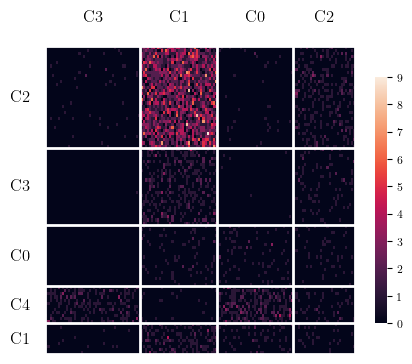

In [20]:

prior_shape = 1
prior_rate = 1

prior = GnedinProcess(gamma=0.55)
likelihood = PoissonGamma(shape=prior_shape, rate=prior_rate)

gen_model = BaseESBM(Y, 
              prior=prior, 
              clustering=[clustering_1, clustering_2],
              likelihood=likelihood, 
              epsilon=1e-10, 
              bipartite=True, 
              verbose=False, 
              rng=rng)

print(gen_model.compute_log_likelihood())
plot_heatmap(gen_model, size=(5,4), bipartite=True, triangular_mask=False)

Instantiate and fit the model. Here we're running a collapsed Gibbs sampler where we sample only the cluster assignment for each nodes.

The model is initialised with a draw from the prior. The class allows to specify a specific clustering by passng a list/np.array. If left to None the model is initialised with one cluster per node.

In [21]:
rng = np.random.default_rng(1)

bb = BaseESBM(Y, 
              prior=prior, 
              likelihood=likelihood, 
              epsilon=1e-10, 
              bipartite=True, 
              verbose=False, 
              clustering='Random',
              rng=rng)

# plot_heatmap(bb, size=(6, 5), bipartite=True, triangular_mask=False)

out = bb.fit(n_iters=200, verbose=True)

starting log likelihood -8870.299716550719
0 -5592.749917642027
time 0.06926300001214258
20 -5226.5727931400925
time 0.7320662080019247
40 -5127.156376640683
time 0.7851810419815592
60 -5082.1993030481635
time 0.8254674169875216
80 -5084.3160943022385
time 0.701302500005113
100 -5083.167167857314
time 0.7113860410172492
120 -5080.19871592391
time 0.6857927499804646
140 -5082.347464595369
time 0.7087914999865461
160 -5078.017714835409
time 0.7075686659954954
180 -5079.644665431169
time 0.6668765420035925
end llk:  -5074.324564089852


We can now use the VI metric to estimate the clustering structure from the posterior draws. 

To estimarte how far our partition is from the true structure we can use the VI metric itself or a graphical analysis.

[0.] [0.15479479]


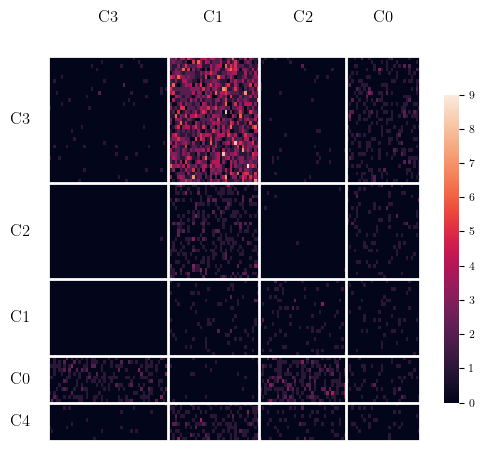

In [22]:
estimated = bb.estimate_cluster_assignment_vi(burn_in=20)
cl1 = estimated[0]
cl2 = estimated[2]
print(VI(clustering_1, cl1), VI(clustering_2, cl2))

plot_heatmap(bb, size=(6, 5), bipartite=True, triangular_mask=True)

We can see that the model recovers the partitioning structure (almost) perfectly

### Bernoulli

We can repeat the same analysis using a Beta-Bernoulli model of the form:
$$
\begin{split}
\mathbf{z} &\sim \text{Gibbs-type prior}\\
\theta_{h, k}|a, b &\sim \text{Beta}(a, b)\\
y_{ui} \mid \mathbf{z}, \Theta &\sim \text{Bernoulli}(\theta_{h, k})
\end{split}
$$

-3746.5935392699084


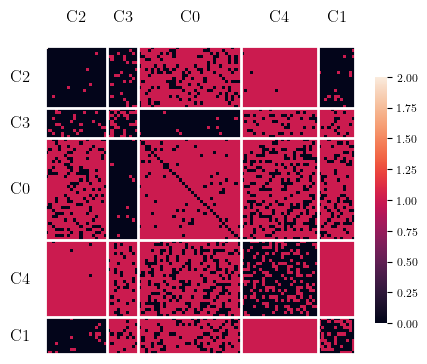

In [23]:
n = 100

rng = np.random.default_rng(1)

sizes = [n//5, n//10, n//3, n//4, n - (n//3)-(n//4)-(n//5)-(n//10)]

clustering = np.array(
    [0 for _ in range(sizes[0])] + 
    [1 for _ in range(sizes[1])] + 
    [2 for _ in range(sizes[2])] +
    [3 for _ in range(sizes[3])] +
    [4 for _ in range(sizes[4])])

Y = generate_bernoulli_data(0.5, 
                            0.5,
                            clustering, 
                            bipartite=False, 
                            rng=rng)

a = np.random.permutation(n)
clustering = clustering[a]
Y = Y[a][:, a]

prior_alpha = 1
prior_beta = 1

prior = GnedinProcess(gamma=0.55)
likelihood = BetaBernoulli(alpha=prior_alpha, beta=prior_beta)

gen_model = BaseESBM(Y, 
              prior=prior, 
              clustering=clustering,
              likelihood=likelihood, 
              epsilon=1e-10, 
              bipartite=False, 
              verbose=False, 
              rng=rng)

print(gen_model.compute_log_likelihood())
plot_heatmap(gen_model, size=(5,4), bipartite=False, triangular_mask=False)

In [24]:
rng = np.random.default_rng(1)

bb = BaseESBM(Y, 
              prior=prior, 
              likelihood=likelihood, 
              epsilon=1e-10, 
              bipartite=False, 
              verbose=False, 
              clustering='Random',
              rng=rng)

# plot_heatmap(bb, size=(6, 5), bipartite=False, triangular_mask=False)

out = bb.fit(n_iters=2000, verbose=True)

starting log likelihood -6492.874696904693
0 -5956.339944748659
time 0.013920208992203698
200 -3966.4758268915243
time 2.4079743750044145
400 -3966.4758268915243
time 2.397850749985082
600 -3966.4758268915243
time 2.4319190840178635
800 -3966.4758268915243
time 2.363231249997625
1000 -3966.4758268915243
time 2.3470189590007067
1200 -3966.4758268915243
time 2.3180960419995245
1400 -3966.4758268915243
time 2.3300485830113757
1600 -3966.4758268915243
time 2.33522179099964
1800 -3966.4758268915243
time 2.3253793750191107
end llk:  -3966.4758268915243


[0.30541888]


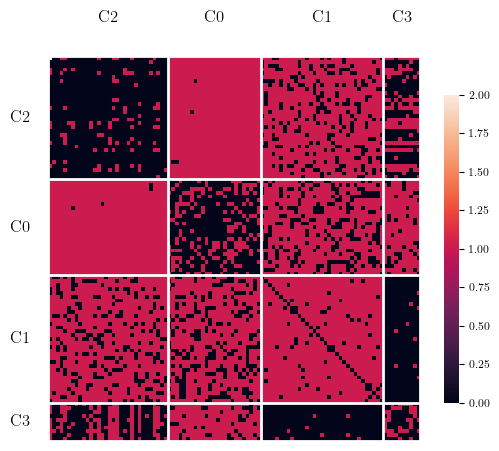

In [25]:
estimated = bb.estimate_cluster_assignment_vi(burn_in=20)
cl1 = estimated[0]
print(VI(clustering, cl1))

plot_heatmap(bb, size=(6, 5), bipartite=False, triangular_mask=False)